In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
from base64 import b64encode
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import HTML, display
from tqdm.notebook import tqdm
import sys

import torch
import torch.nn as nn
import torch.optim as optim
from transformers import TimesformerModel, TimesformerConfig
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from torchinfo import summary
import copy

2025-06-14 10:47:19.715438: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749898039.916862      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749898039.977944      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
features_test = np.load('/kaggle/input/dataset-fp-deep-learning/features_test.npy')
features_train = np.load('/kaggle/input/dataset-fp-deep-learning/features_train.npy')
labels_test = np.load('/kaggle/input/dataset-fp-deep-learning/labels_test.npy')
labels_train = np.load('/kaggle/input/dataset-fp-deep-learning/labels_train.npy')
test_indices = np.load('/kaggle/input/dataset-fp-deep-learning/test_indices.npy')
video_files_paths = np.load('/kaggle/input/dataset-fp-deep-learning/video_files_paths.npy')

In [3]:
print(features_train.shape, features_test.shape)
print(labels_train.shape, labels_test.shape)

(1600, 16, 112, 112, 3) (400, 16, 112, 112, 3)
(1600, 2) (400, 2)


# Making the Dataset and DataLoader Object

In [4]:
class ViolenceDataset(Dataset):
  def __init__(self, features, labels):
    self.features = features
    self.labels = labels

  def __len__(self):
    return len(self.features)

  def __getitem__(self, idx):
    x = self.features[idx]
    x = torch.from_numpy(x).permute(0, 3, 1, 2).float()
    y = torch.tensor(self.labels[idx])
    return x, y

val_ratio = 0.2

train_dataset = ViolenceDataset(features_train, labels_train)
test_dataset = ViolenceDataset(features_test, labels_test)

train_size = int((1 - val_ratio) * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Building the Model

In [5]:
def interpolate_pos_encoding_1d(old_posemb, new_posemb):
    cls_token = old_posemb[:, :1, :]  # (1, 1, C)
    old_tokens = old_posemb[:, 1:, :]  # (1, N_old, C)
    new_tokens = new_posemb[:, 1:, :]  # (1, N_new, C)

    # Interpolate over the sequence (N tokens)
    old_len = old_tokens.shape[1]
    new_len = new_tokens.shape[1]

    # Resize as (1, C, N_old) → interpolate → (1, C, N_new)
    old_tokens = old_tokens.permute(0, 2, 1)
    new_tokens_interp = nn.functional.interpolate(old_tokens, size=new_len, mode='linear', align_corners=False)
    new_tokens_interp = new_tokens_interp.permute(0, 2, 1)

    return torch.cat((cls_token, new_tokens_interp), dim=1)  # (1, N_new+1, C)


class TimeSformer(nn.Module):
  def __init__(self, num_classes=2, freeze_backbone=True):
    super(TimeSformer, self).__init__()
    # Step 1: Create config with your input shape
    config = TimesformerConfig.from_pretrained(
        "facebook/timesformer-base-finetuned-k400",
        num_frames=16,
        image_size=112  # Make sure this matches your input size
    )

    # Step 2: Load model without weights first
    self.backbone = TimesformerModel(config)

    # Step 3: Load pretrained state dict
    pretrained_model = TimesformerModel.from_pretrained("facebook/timesformer-base-finetuned-k400")
    state_dict = pretrained_model.state_dict()

    # Step 4: Resize positional embeddings if they don't match
    old_posemb = state_dict["embeddings.position_embeddings"]
    new_posemb = self.backbone.embeddings.position_embeddings

    if old_posemb.shape != new_posemb.shape:
        print(f"Resizing position embeddings: {old_posemb.shape} → {new_posemb.shape}")
        new_posemb_resized = interpolate_pos_encoding_1d(old_posemb, new_posemb)
        state_dict["embeddings.position_embeddings"] = new_posemb_resized

    if "embeddings.time_embeddings" in state_dict:
        old_timemb = state_dict["embeddings.time_embeddings"] # (1, 8, 768)
        new_timemb = self.backbone.embeddings.time_embeddings # (1, 16, 768)

        if old_timemb.shape != new_timemb.shape:
            print(f"Resizing time embeddings: {old_timemb.shape} → {new_timemb.shape}")
            old_timemb = old_timemb.permute(0, 2, 1) # (1, 768, 8)
            new_timemb_interp = nn.functional.interpolate(old_timemb, size=new_timemb.shape[1], mode='linear', align_corners=False) # (1, 768, 16)
            new_timemb_interp = new_timemb_interp.permute(0, 2, 1) # (1, 16, 768)

            state_dict["embeddings.time_embeddings"] = new_timemb_interp

    # Load with updated state dict
    self.backbone.load_state_dict(state_dict, strict=False)

    self.classifier = nn.Sequential(
        nn.Dropout(0.25),
        nn.Linear(self.backbone.config.hidden_size, 256),
        nn.ReLU(),
        nn.Dropout(0.25),

        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Dropout(0.25),

        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Dropout(0.25),

        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Dropout(0.25),

        nn.Linear(32, num_classes)
    )

    if freeze_backbone:
      for param in self.backbone.parameters():
        param.requires_grad = False

  def forward(self, video):
    outputs = self.backbone(video)
    cls_token = outputs.last_hidden_state[:, 0]
    return self.classifier(cls_token)

In [6]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0, verbose=False):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.best_loss = None
        self.no_improvement_count = 0
        self.stop_training = False
        self.best_weight = None

    def check_early_stop(self, val_loss, model):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.no_improvement_count = 0
            self.best_weight = copy.deepcopy(model.state_dict())
        else:
            self.no_improvement_count += 1
            if self.no_improvement_count >= self.patience:
                self.stop_training = True
                model.load_state_dict(self.best_weight)
                if self.verbose:
                    print(f"Stopping early as no improvement has been observed. With best val_loss at {self.best_loss}")

# Initialize early stopping
early_stopping = EarlyStopping(patience=10, verbose=True)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TimeSformer(freeze_backbone=True).to(device)

summary(model, input_size=(32, 16, 3, 112, 112))

config.json:   0%|          | 0.00/22.7k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/486M [00:00<?, ?B/s]

Resizing position embeddings: torch.Size([1, 197, 768]) → torch.Size([1, 50, 768])
Resizing time embeddings: torch.Size([1, 8, 768]) → torch.Size([1, 16, 768])


model.safetensors:   0%|          | 0.00/486M [00:00<?, ?B/s]

Layer (type:depth-idx)                                            Output Shape              Param #
TimeSformer                                                       [32, 2]                   --
├─TimesformerModel: 1-1                                           [32, 785, 768]            --
│    └─TimesformerEmbeddings: 2-1                                 [32, 785, 768]            51,456
│    │    └─TimesformerPatchEmbeddings: 3-1                       [512, 49, 768]            (590,592)
│    │    └─Dropout: 3-2                                          [512, 50, 768]            --
│    │    └─Dropout: 3-3                                          [1568, 16, 768]           --
│    └─TimesformerEncoder: 2-2                                    [32, 785, 768]            --
│    │    └─ModuleList: 3-4                                       --                        (120,508,416)
│    └─LayerNorm: 2-3                                             [32, 785, 768]            (1,536)
├─Sequential: 1-2 

# Training Loop

In [8]:
optimizer = optim.Adam(
    model.classifier.parameters(), lr= 0.01
)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.6, patience=5, verbose=True, min_lr=5e-5)

criterion = nn.CrossEntropyLoss()

EPOCH = 50
train_losses = []
val_losses = []
train_accuracies , val_accuracies = [], []
for epoch in range(EPOCH):
    # FASE TRAINING
    model.train()
    total_loss = 0.0
    all_labels, all_preds = [], []
    
    for videos, labels in tqdm(train_loader, desc ="Training Loop"):
        videos, labels = videos.to(device), labels.to(device)
        labels = torch.argmax(labels, dim=1)

        optimizer.zero_grad()
        outputs = model(videos)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * videos.size(0)
        preds = outputs.argmax(dim=1).detach()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

    train_loss = total_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    acc = accuracy_score(all_labels, all_preds)
    train_accuracies.append(acc)

    # FASE EVALUASI
    all_labels, all_preds = [], []
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for videos, labels in tqdm(val_loader, desc="Validation Loop"):
            videos, labels = videos.to(device), labels.to(device)
            labels = torch.argmax(labels, dim=1) 

            outputs = model(videos)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * videos.size(0)
            preds = outputs.argmax(dim=1).detach()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    val_loss = total_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    acc = accuracy_score(all_labels, all_preds)
    val_accuracies.append(acc)

    # Check early stopping condition
    early_stopping.check_early_stop(val_loss, model)
    scheduler.step(val_loss)
    if early_stopping.stop_training:
        print(f"Early stopping at epoch {epoch}")
        break

    print(f"Epoch {epoch+1}/{EPOCH} - Train loss: {train_loss}, Val loss: {val_loss}")
    print(f"Train accuracy: {train_accuracies[-1]}, Val accuracy: {acc}")

Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/50 - Train loss: 0.5724629111588001, Val loss: 0.49555777907371523
Train accuracy: 0.72734375, Val accuracy: 0.78125


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2/50 - Train loss: 0.4014276433736086, Val loss: 0.4266953945159912
Train accuracy: 0.83984375, Val accuracy: 0.828125


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3/50 - Train loss: 0.35125822834670545, Val loss: 0.5686835438013077
Train accuracy: 0.85625, Val accuracy: 0.71875


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4/50 - Train loss: 0.3287513982504606, Val loss: 0.30735373347997663
Train accuracy: 0.88515625, Val accuracy: 0.846875


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5/50 - Train loss: 0.29719970673322677, Val loss: 0.4528686821460724
Train accuracy: 0.8984375, Val accuracy: 0.878125


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6/50 - Train loss: 0.25827693566679955, Val loss: 0.31446309834718705
Train accuracy: 0.9, Val accuracy: 0.8625


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7/50 - Train loss: 0.25138531122356655, Val loss: 0.41934930384159086
Train accuracy: 0.91328125, Val accuracy: 0.871875


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8/50 - Train loss: 0.23823299733921885, Val loss: 0.31741916537284853
Train accuracy: 0.90390625, Val accuracy: 0.8625


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9/50 - Train loss: 0.21998987682163715, Val loss: 0.3407230608165264
Train accuracy: 0.9078125, Val accuracy: 0.85


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10/50 - Train loss: 0.27242162162438033, Val loss: 0.3073399066925049
Train accuracy: 0.89453125, Val accuracy: 0.853125


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11/50 - Train loss: 0.19401499843224884, Val loss: 0.35208316072821616
Train accuracy: 0.9265625, Val accuracy: 0.896875


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 12/50 - Train loss: 0.20410895831882953, Val loss: 0.25979371592402456
Train accuracy: 0.928125, Val accuracy: 0.896875


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 13/50 - Train loss: 0.18966089403256775, Val loss: 0.2965139128267765
Train accuracy: 0.93203125, Val accuracy: 0.896875


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 14/50 - Train loss: 0.13769463468343018, Val loss: 0.26905798316001894
Train accuracy: 0.94921875, Val accuracy: 0.9


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 15/50 - Train loss: 0.14075809326022864, Val loss: 0.28388205617666246
Train accuracy: 0.94921875, Val accuracy: 0.909375


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 16/50 - Train loss: 0.14380578873679042, Val loss: 0.25067673027515414
Train accuracy: 0.9421875, Val accuracy: 0.896875


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 17/50 - Train loss: 0.1712954981951043, Val loss: 0.3091271921992302
Train accuracy: 0.94375, Val accuracy: 0.890625


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 18/50 - Train loss: 0.17072857534512878, Val loss: 0.2973627239465714
Train accuracy: 0.9421875, Val accuracy: 0.8875


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 19/50 - Train loss: 0.17275872649624943, Val loss: 0.30013107806444167
Train accuracy: 0.94453125, Val accuracy: 0.903125


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 20/50 - Train loss: 0.13445389056578277, Val loss: 0.368846046179533
Train accuracy: 0.9421875, Val accuracy: 0.896875


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 21/50 - Train loss: 0.13871534271165728, Val loss: 0.38069843463599684
Train accuracy: 0.95625, Val accuracy: 0.9


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 22/50 - Train loss: 0.14155111047439278, Val loss: 0.31134125143289565
Train accuracy: 0.9546875, Val accuracy: 0.89375


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 23/50 - Train loss: 0.1576887097209692, Val loss: 0.31123544201254844
Train accuracy: 0.94609375, Val accuracy: 0.89375


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 24/50 - Train loss: 0.0937388373306021, Val loss: 0.37588092386722566
Train accuracy: 0.971875, Val accuracy: 0.896875


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 25/50 - Train loss: 0.09557282077148557, Val loss: 0.3545779883861542
Train accuracy: 0.9640625, Val accuracy: 0.896875


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Stopping early as no improvement has been observed. With best val_loss at 0.25067673027515414
Early stopping at epoch 25


In [9]:
# Save the model
torch.save(model.state_dict(), 'model_adam.pth')

# # Load the model
# model = TimeSformer()
# model.load_state_dict(torch.load('/content/model.pth'))
# model.to(device)

# Model Evaluation

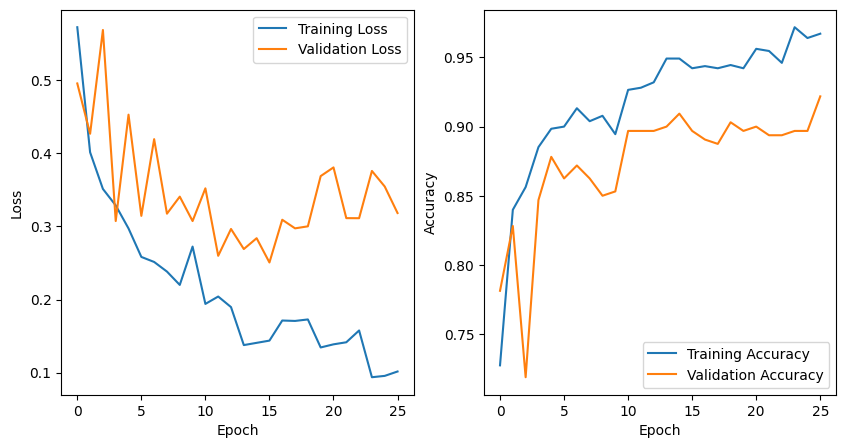

In [10]:
# Plot Losses and Accuracies
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Predicting the Test Set

In [11]:
# Predict the test dataset
all_labels, all_preds = [], []
model.eval()
total_loss = 0.0
with torch.no_grad():
  for videos, labels in tqdm(test_loader, desc="Test Loop"):
    videos, labels = videos.to(device), labels.to(device)

    outputs = model(videos)
    preds = outputs.argmax(dim=1).detach()
    all_labels.extend(labels.cpu().numpy())
    all_preds.extend(preds.cpu().numpy())

all_labels = [np.argmax(label) for label in all_labels]
acc = accuracy_score(all_labels, all_preds)

Test Loop:   0%|          | 0/13 [00:00<?, ?it/s]

In [12]:
print(f"Test set accuracy is {acc}")

Test set accuracy is 0.925


              precision    recall  f1-score   support

           0       0.89      0.97      0.93       199
           1       0.97      0.88      0.92       201

    accuracy                           0.93       400
   macro avg       0.93      0.93      0.92       400
weighted avg       0.93      0.93      0.92       400



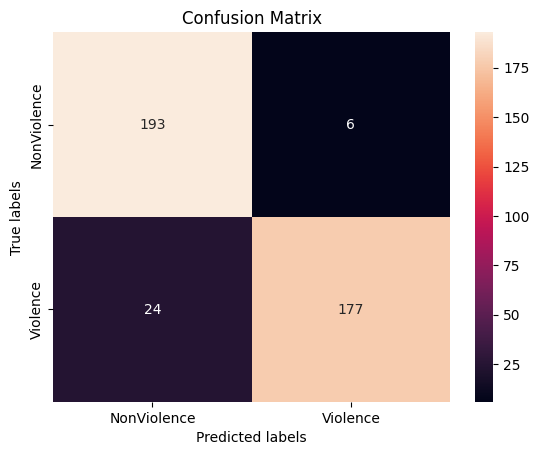

In [13]:
# Show the Classification Report and Confusion Matrix
print(classification_report(all_labels, all_preds))

ax= plt.subplot()
cm=confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='g', ax=ax);

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['NonViolence', 'Violence']); ax.yaxis.set_ticklabels(['NonViolence', 'Violence']);

# Predicting Random Videos From the Test Set

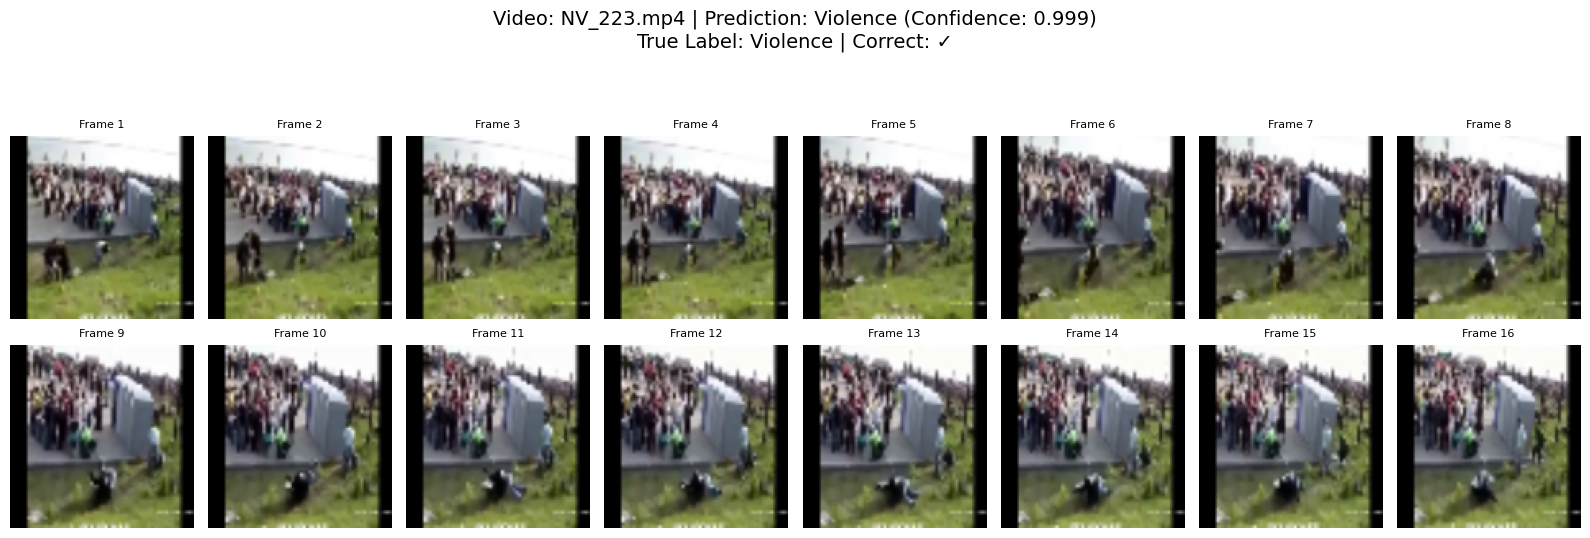

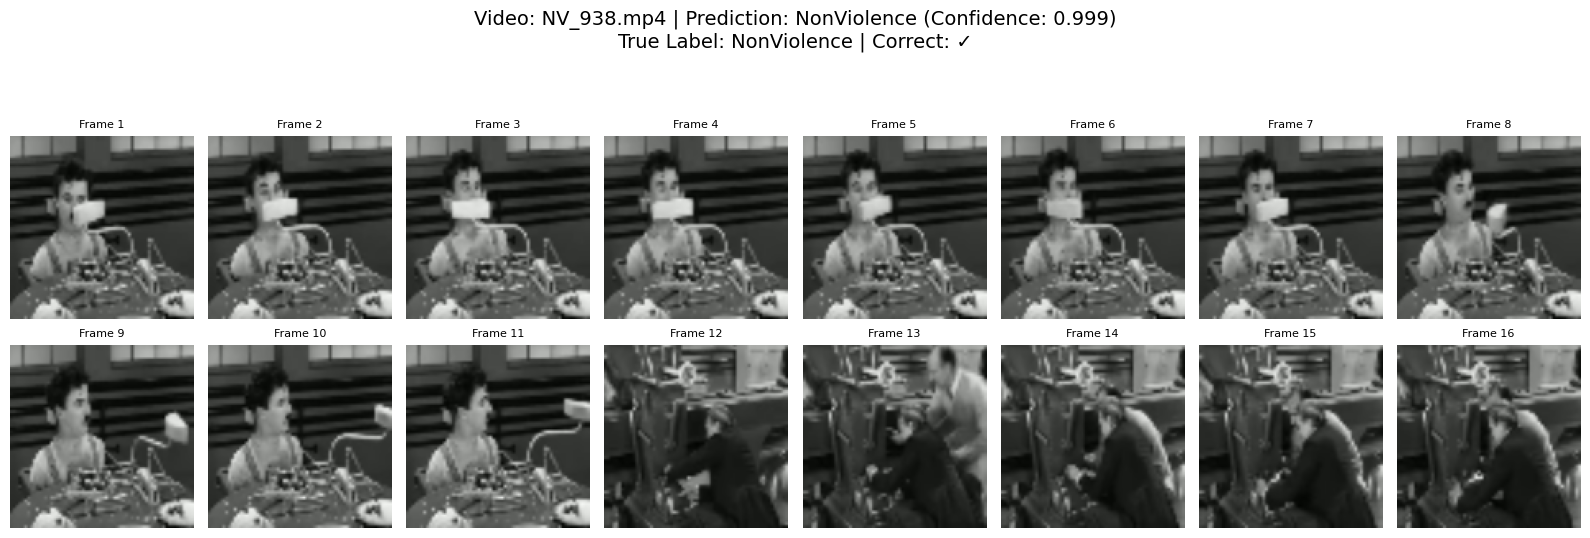

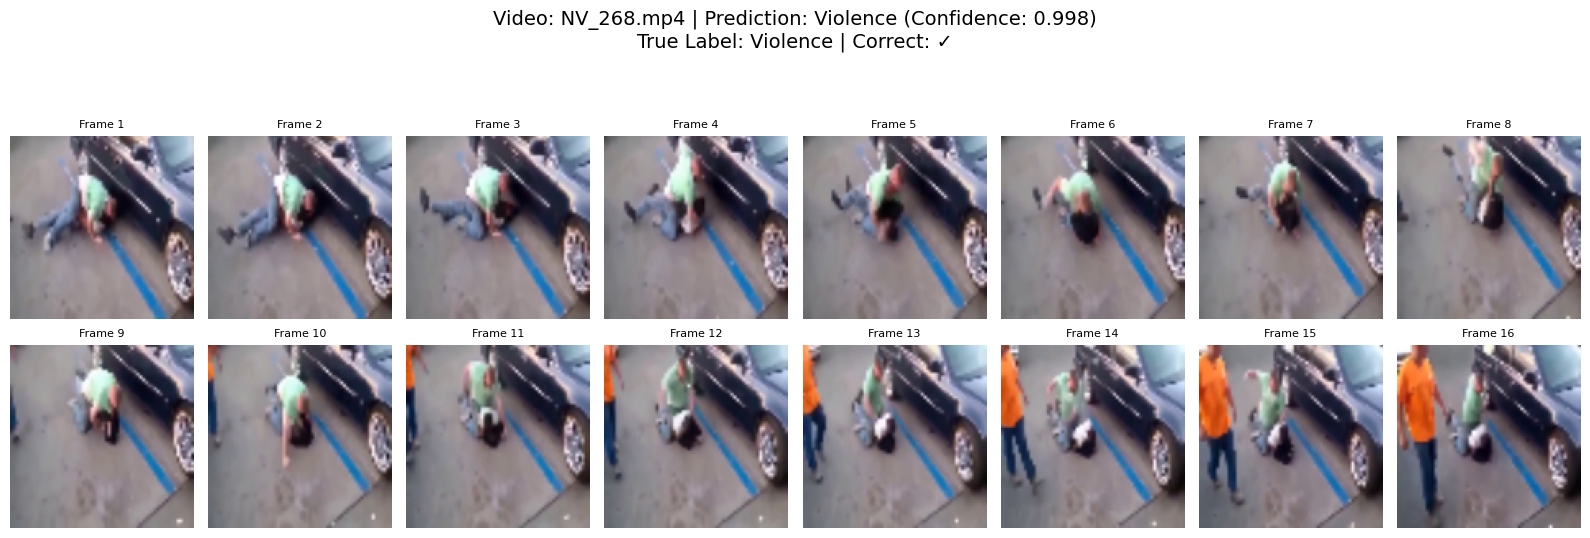

In [14]:
# Choose random indices
num_samples = 3  # or however many you want
indices = random.sample(range(len(features_test)), num_samples)

# Visualization function
def visualize_prediction(video, true_label, pred_label, confidence, video_path):
    plt.figure(figsize=(16, 6))
    plt.suptitle(
        f"Video: {video_path.split('/')[-1]} | "
        f"Prediction: {'Violence' if pred_label==1 else 'NonViolence'} "
        f"(Confidence: {confidence:.3f})\n"
        f"True Label: {'Violence' if true_label==1 else 'NonViolence'} | "
        f"Correct: {'✓' if pred_label == true_label else '✗'}",
        fontsize=14
    )

    for i, frame in enumerate(video):
        frame = frame[..., ::-1]    # fix color
        plt.subplot(2, 8, i+1)
        plt.imshow(frame)
        plt.axis("off")
        plt.title(f"Frame {i+1}", fontsize=8)
        border_color = 'green' if pred_label == true_label else 'red'
        for spine in plt.gca().spines.values():
            spine.set_edgecolor(border_color)
            spine.set_linewidth(2)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Run predictions and visualize
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

for idx in indices:
    video = features_test[idx]  # shape: (16, 112, 112, 3)
    true_label = int(np.argmax(labels_test[idx]))
    video_tensor = torch.tensor(video).permute(0, 3, 1, 2).unsqueeze(0).float().to(device)  # (1, 16, 3, 112, 112)

    with torch.no_grad():
      output = model(video_tensor)         # raw logits, shape: (1, 1)
      probs = nn.functional.softmax(output, dim=1)         # shape [1, 2]
      prob_value, pred_label = torch.max(probs, dim=1)  # highest probability and its index

    # Convert to scalar
    pred_label = pred_label.item()      # 0 or 1
    prob_value = prob_value.item()      # confidence (0.0 to 1.0)
    visualize_prediction(video, true_label, pred_label, prob_value, video_files_paths[idx])